<a href="https://colab.research.google.com/github/ctate7163/radiometry/blob/main/radiometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Radiometry for exposure time calculation

This notebook estimates the camera design requirements

All quantities are in SI units unless stated otherwise.

Symbols used below.

| Symbol | Name | SI units | Note |
| :-- | ------ | :----- | ------ |
| Q$_e$ | radiant energy | J |  |
| 𝛷$_e$ | radiant flux | W |  |
| I$_e$$_Ω$ | radiant intensity | W/sr |  |
| L$_e$$_Ω$ | radiance | W/sr/m$^2$ |  |
| E$_e$ | irradiance | W/m$^2$ | also flux density |
| M$_e$ | exitance | W/m$^2$ | also emittance |
| Ω | solid angle | sr |  |
| λ | wavelength | meters |  |
| α | albedo |  - | also reflectance |
| T | transmission | - |  |
| S | signal | e$^-$ | detector signal in electrons |
| t | exposure time | sec |  |
| r | radius | m |  |
| d | distance | m |  |
| l | length | m |  |
| A | area | m$^2$ |  |
| QE | quantum efficency | e$^-$/photon |  |
| i | incidence | rad |  |
|  |  |  |  |

See Wikipedia [here](https://en.wikipedia.org/wiki/Radiometry) for notation conventions

Solar spectrum is the E-490-00 standard downloaded from [here](https://www.nrel.gov/grid/solar-resource/spectra-astm-e490.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
# from astropy.table import Table
# import astropy.units as u

In [2]:
!pip install PySpectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 54.9 MB/s eta 0:00:00
  Created wheel for PySpectral: filename=pyspectral-0.13.5-py2.py3-none-any.whl size=702097 sha256=7dc153f5f353d5b536c07a14039439f80d4717e9d8c83303dcdcd9cedf6d219a
  Stored in directory: /root/.cache/pip/wheels/f7/ab/97/aaee93364f115f1dbed177408b70128ea4af99d8c04e9a3600
Successfully built PySpectral


In [3]:

# Set wavelength range in meters

l_min  = 200e-9
l_max  = 1201e-9
l_bin  = 10e-9

l = np.arange(l_min,l_max,l_bin)

In [4]:
# Get Solar radiance at 1 AU

from pyspectral.solar import SolarIrradianceSpectrum
solar_irr = SolarIrradianceSpectrum()

l__ = solar_irr.wavelength/1e6
E__ = solar_irr.irradiance*1e6
L__ = E__*4*np.pi

from scipy.stats import binned_statistic

def new_irradiance(wavelength, irradiance, new_wavelength):
    wavelength = np.array(wavelength)
    irradiance = np.array(irradiance)

    # Define bin edges spanning the range of the data.
    bins = new_wavelength

    # Use binned_statistic to compute the mean irradiance per bin.
    stat, bin_edges, _ = binned_statistic(wavelength, irradiance, statistic='mean', bins=bins)

    # Compute bin centers from bin edges.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    return stat


l_bins = np.arange(l_min-l_bin/2,l_max+l_bin/2,l_bin)
E_1au = new_irradiance( l__, E__, l_bins )
L_1au = new_irradiance( l__, L__, l_bins )

# E = np.interp(l,l_,E_)
# L = np.interp(l,l_,L_)

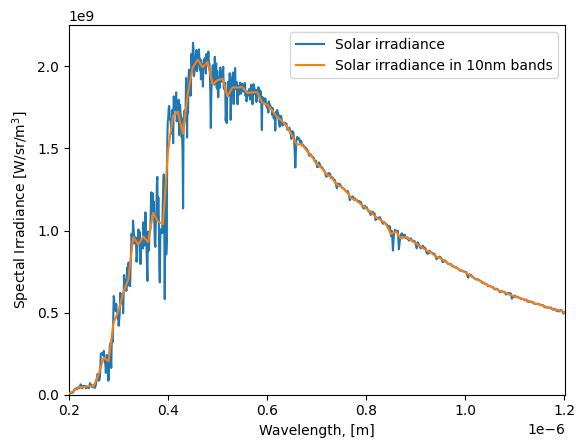

In [5]:
# Plot Solar radiance at 1 AU

plt.plot(l__,E__)
plt.plot(l, E_1au, zorder=10)

plt.xlabel('Wavelength, [m]')
plt.ylabel('Spectal Irradiance [W/sr/m$^3$]')
plt.legend(['Solar irradiance', 'Solar irradiance in 10nm bands', ])
plt.xlim([l_min,l_max])
plt.ylim(bottom=0)
plt.show()


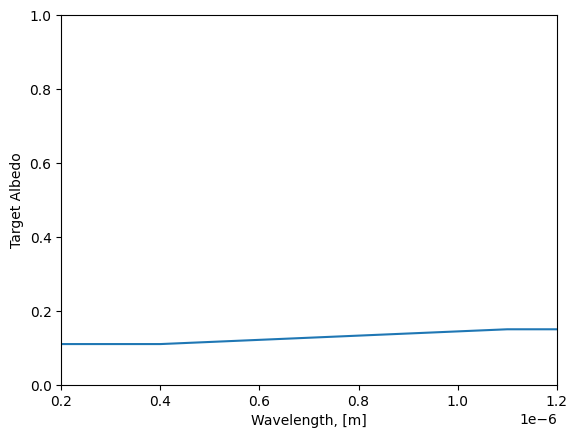

In [6]:
# define target albedo


def albedoSpectrum( v_, r_, l=l):
    l_      = [300e-9,400e-9,1100e-9]
    albedo_ = [v_,v_,r_]
    albedo  = np.interp(l,l_,albedo_)
    return albedo

# Mars
a = albedoSpectrum( 0.05, 0.1, l )

# Psyche
a = albedoSpectrum( 0.11, 0.15, l )

plt.plot(l,a)
plt.xlabel('Wavelength, [m]')
plt.ylabel('Target Albedo')
plt.xlim([l_min,l_max])
plt.ylim([0,1])
plt.show()

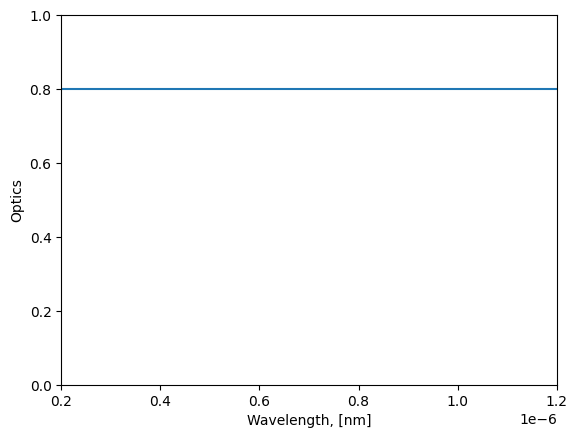

In [7]:
# Transission of optics

# Transission of filter

# “CLR”: 400-680 nm
l_        = [ 400, 1000  ]
T_optics_ = [  80,   80  ]

T_optics = np.interp(l,np.array(l_)*1e-9,np.array(T_optics_)/100)


plt.plot(l,T_optics)
plt.xlabel('Wavelength, [nm]')
plt.ylabel('Optics')
plt.xlim([l_min,l_max])
plt.ylim([0,1])
plt.show()

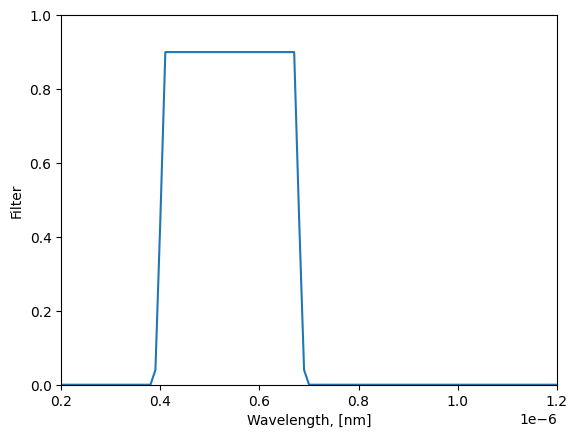

In [8]:
# Transission of filter

# “CLR”: 400-680 nm
l_        = [ 380, 390, 400, 410, 670, 680, 690, 700 ]
T_filter_ = [   0,   4,  45,  90,  90,  45,   4,  0  ]

T_filter = np.interp(l,np.array(l_)*1e-9,np.array(T_filter_)/100)

plt.plot(l,T_filter)
plt.xlabel('Wavelength, [nm]')
plt.ylabel('Filter')
plt.xlim([l_min,l_max])
plt.ylim([0,1])
plt.show()

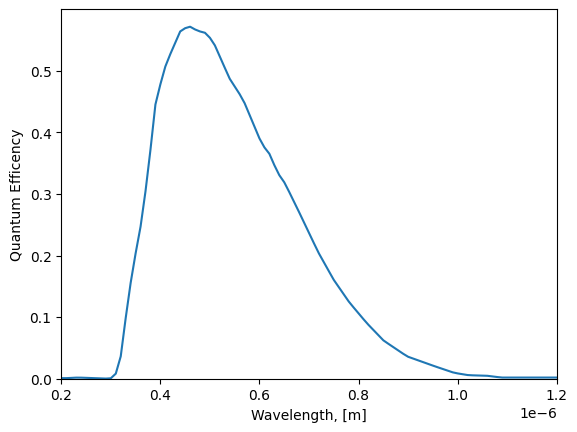

In [9]:
# Quantum efficency and other detector properties

# Kai2020
pixelsize   = 7.4e-6 # m
readnoise   = 24 # electrons
fullwell    = 3e4 #electrons
df = pd.read_csv( "https://raw.githubusercontent.com/ctate7163/radiometry/main/kai2020_qe.csv" )
l_  = df['x']*1e-9
try: qe_ = df['y']
except: qe_ = df[' y']
qe = np.interp(l,l_,qe_)

plt.plot(l,qe)
plt.xlabel('Wavelength, [m]')
plt.ylabel('Quantum Efficency')
plt.xlim([l_min,l_max])
plt.ylim(bottom=0)
plt.show()


In [10]:
# Physical constants
hc      = 6.62607015e-34 # SI units

In [11]:
# Optical specifications

focalLength = 3.51
aperture    = 0.35
fNumber     = focalLength/aperture

# for Psyche
fNumber     = 4.4
focalLength = 0.148

# Mission Properties

altitude    = 704e3 # m
groundspeed = 62 # m/s

halfpixel   = altitude*0.5*pixelsize/focalLength
halfpixtime = halfpixel/groundspeed


halfpixel, halfpixtime

(17.6, 0.2838709677419355)



```
# This is formatted as code
```

# New Section

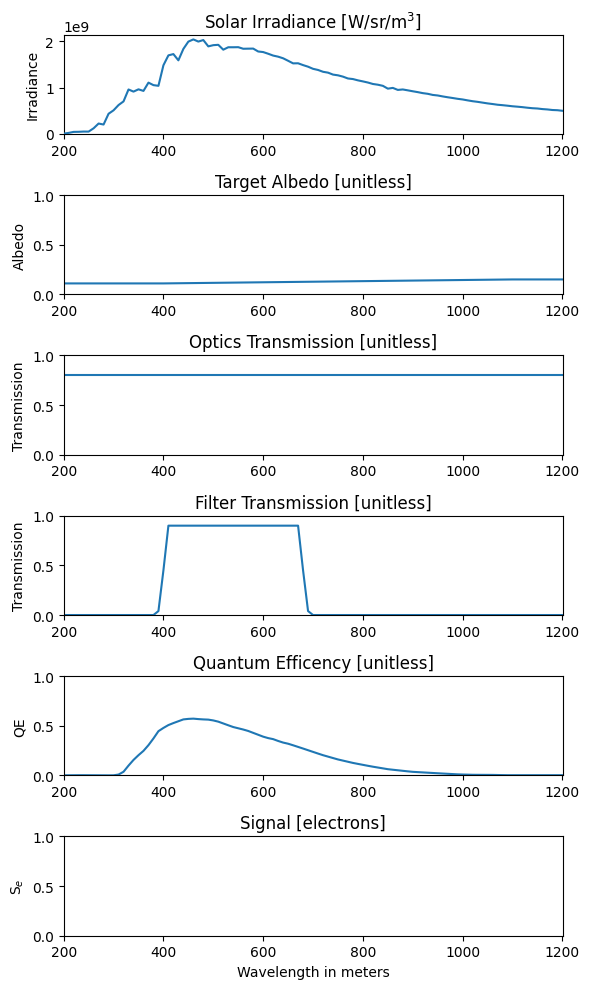

In [12]:
plt.figure( figsize=(6,10) )

n = 6
plt.subplot( n, 1, 1)

plt.plot(l*1e9, E_1au, zorder=10)
# plt.plot(l__*1e9,E__)

# plt.xlabel('Wavelength, [m]')
plt.title('Solar Irradiance [W/sr/m$^3$]')
plt.ylabel('Irradiance')
# plt.legend(['Solar irradiance', 'Solar irradiance in 10nm bands', ])
plt.xlim([l_min*1e9,l_max*1e9])
plt.ylim(bottom=0)


plt.subplot( n, 1, 2)

plt.plot(l*1e9,a)
# plt.xlabel('Wavelength, [m]')
plt.title('Target Albedo [unitless]')
plt.ylabel('Albedo')
plt.xlim([l_min*1e9,l_max*1e9])
plt.ylim([0,1])


plt.subplot( n, 1, 3)

plt.plot(l*1e9,T_optics)
# plt.xlabel('Wavelength, [nm]')
plt.title('Optics Transmission [unitless]')
plt.ylabel('Transmission')
plt.xlim([l_min*1e9,l_max*1e9])
plt.ylim([0,1])


plt.subplot( n, 1, 4)

plt.plot(l*1e9,T_filter)
# plt.xlabel('Wavelength, [nm]')
plt.title('Filter Transmission [unitless]')
plt.ylabel('Transmission')
plt.xlim([l_min*1e9,l_max*1e9])
plt.ylim([0,1])


plt.subplot( n, 1, 5)

plt.plot(l*1e9,qe)
# plt.xlabel('Wavelength, [m]')
plt.title('Quantum Efficency [unitless]')
plt.ylabel('QE')
plt.xlim([l_min*1e9,l_max*1e9])
plt.ylim(bottom=0)
plt.ylim([0,1])



plt.subplot( n, 1, 6)

plt.title('Signal [electrons]')
plt.ylabel('S$_e$')
plt.xlim([l_min*1e9,l_max*1e9])
plt.xlabel('Wavelength in nanometers')



plt.tight_layout()
plt.show()
